# Reinforcement-learning calibration of coherent-statereceivers on variable-loss optical channels

Bilkis - Calsamiglia - Rosati

In this notebook we compare two methods for computing the Helstrom bound for binary coherent-state discrimination, transmitted over fading channel. The channel consists on a mixture between an attenuating channel and a noiseless one. First method considered is via Gram matrix; consider $B=\sqrt{G}$, s.t. $B^\dagger B = G$, with $G_{ij} = \langle \psi_i |\psi_j \rangle$; by noticing that $(B^\dagger B )_{i,j}$ corresponds to the scalar product between columns of $B$ (that is, $(B^\dagger B )_{i,j} = (B[:,i], B[:,j])$, then the columns of B give a representation of states $|\psi_j\rangle$, with the same original overlaps. Thus, states of the form $\sum_j \pi_j |\psi_j\rangle\langle\psi_j|$ can be written in a new orthonormal basis (spanned by $\psi_j$), even if the original states live in an infinite-dimensional space. Moreover, we compare this method with traditional truncation of the Fock basis.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import optimize, linalg
from math import erf, erfc
from scipy.optimize import *
import os


### Gram schmidt

In [3]:
def overlap(a1,a2):
    return np.exp(-0.5*abs(a1-a2)**2)

def rho0(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,0]]*2) + (1-pr_at0)*np.outer(*[B[:,1]]*2)
def rho1(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,2]]*2) + (1-pr_at0)*np.outer(*[B[:,3]]*2)

def helstrom_success_fun(amplitude, epsilon1=1e-2, epsilon2=1.):
    at1 = np.sqrt(epsilon1)
    at2 = np.sqrt(epsilon2)
    a1=amplitude
    a2=-amplitude
    gram = np.zeros((4,4))
    for indi, i in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
        for indj, j in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
            gram[indi,indj] = overlap(i,j)
    B = linalg.sqrtm(gram)
    q0 = 0.5
    q1 = 1-q0
    rho = q0*rho0(B) - q1*rho1(B)
    trace_norm = np.sum(np.abs(np.linalg.eigvals(rho)))
    helstrom_success = (1+trace_norm)/2
    return helstrom_success

### Truncation

In [4]:
def coherent_state(alpha,Ntrunc=100):
    return np.exp(-alpha**2/2)*np.array([np.power(alpha,n)/np.sqrt(float(np.math.factorial(n))) for n in range(Ntrunc)])

def rho(state):
    if len(list(state.shape))>1:
        pass
    else:
        state = np.expand_dims(state, [0])
    return np.dot(state.T,state)

def helstrom_trunc(alpha, epsilon1=0.01, epsilon2=1):
    rhoAP = rho(coherent_state(np.sqrt(epsilon2)*alpha))
    rhoAM = rho(coherent_state(-np.sqrt(epsilon2)*alpha))
    rhoBP = rho(coherent_state(np.sqrt(epsilon1)*alpha))
    rhoBM = rho(coherent_state(-np.sqrt(epsilon1)*alpha))
    return 0.5*(1+ 0.5*np.sum(np.abs(  np.linalg.eigvals((rhoAP + rhoBP)/2  - (rhoAM + rhoBM)/2 ))))

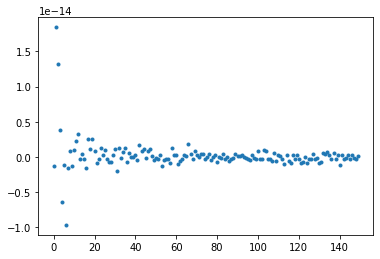

In [5]:
amps = np.linspace(1e-4, 2, 150)
h_gram = np.array([helstrom_success_fun(a) for a in amps])
h_trunc = np.array([helstrom_trunc(a) for a in amps])
plt.plot(h_gram - h_trunc,'.')


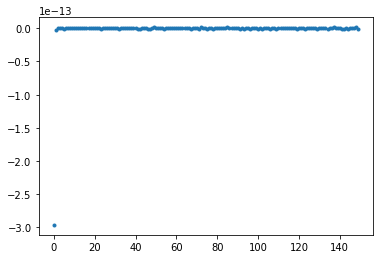

In [6]:

amps = np.linspace(1e-4, 2, 150)
h_gram = np.array([helstrom_success_fun(a,epsilon1=0.4,epsilon2=0.9) for a in amps])
h_trunc = np.array([helstrom_trunc(a,epsilon1=0.4,epsilon2=0.9) for a in amps])
plt.plot(h_gram - h_trunc,'.')

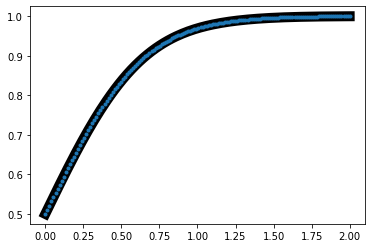

In [7]:
plt.plot(amps,h_gram, linewidth=10, color="black")
plt.plot(amps,h_trunc,'.')

### Homodyne

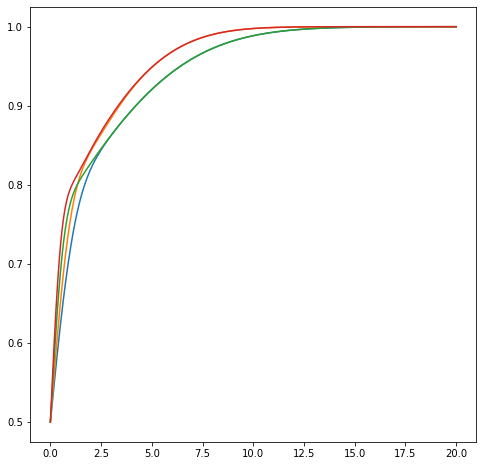

In [8]:
def homodyne_success(a):
    return (1+ erf(np.sqrt(2)*a))/2

def fading_homodyne_success(a, epsilon1=1e-2,epsilon2=1. ,pat0=0.5):
    return pat0*homodyne_success(np.sqrt(epsilon1)*a) + (1-pat0)*homodyne_success(np.sqrt(epsilon2)*a)

amps = np.linspace(1e-4,20,1000)
fad = [fading_homodyne_success(a,epsilon1=1e-2,epsilon2=0.3) for a in amps]
hels = [helstrom_success_fun(a,epsilon1=1e-2,epsilon2=0.3) for a in amps]

fad1 = [fading_homodyne_success(a,epsilon1=1e-2,epsilon2=1) for a in amps]
hels1 = [helstrom_success_fun(a,epsilon1=1e-2,epsilon2=1) for a in amps]

plt.figure(figsize=(8,8))
plt.plot(amps,fad)
plt.plot(amps,hels)
plt.plot(amps,fad1)
plt.plot(amps,hels1)

## Exploring different regions of parameters

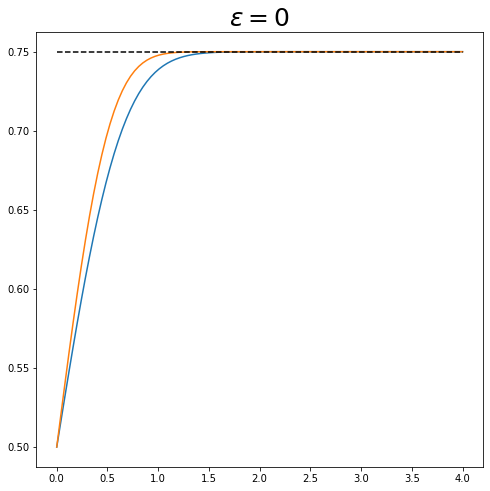

In [9]:
amps = np.linspace(1e-4,4,100)
fad = np.array([fading_homodyne_success(a, epsilon1=0) for a in amps])
hels = np.array([helstrom_success_fun(a,epsilon1= 0) for a in amps])
plt.figure(figsize=(8,8))
plt.title(r'$\epsilon = 0$',size=25)
plt.plot(amps,fad)
plt.plot(amps,hels)
plt.plot(amps,.75*np.ones(len(amps)),'--',color="black")
#If $\epsilon=0$, and energy is very high, two of the four 
#signals will be undistinguishable (and will go to |0>).
#Then random guessing for the attenuated signal gives the .25 average score,
#plus the signals from each side that don't get attenuated

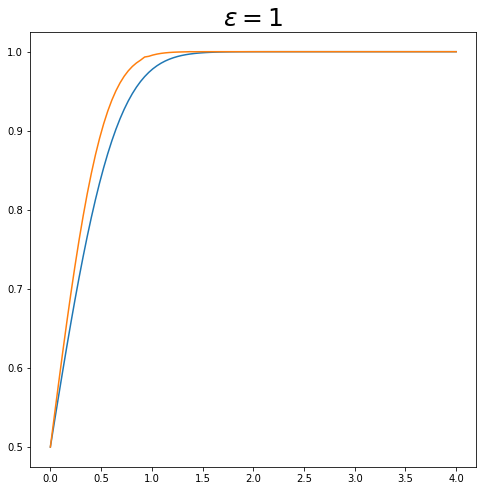

In [10]:
amps = np.linspace(1e-4,4,100)
fad = np.array([fading_homodyne_success(a, epsilon1=1) for a in amps])
hels = np.array([helstrom_success_fun(a,epsilon1= 1) for a in amps])
plt.figure(figsize=(8,8))
plt.title(r'$\epsilon = 1$',size=25)
plt.plot(amps,fad)
plt.plot(amps,hels)
## When $\epsilon=1$ we recover BPSK

100it [00:00, 403.64it/s]


Text(0.5, 0, '$<H>$')

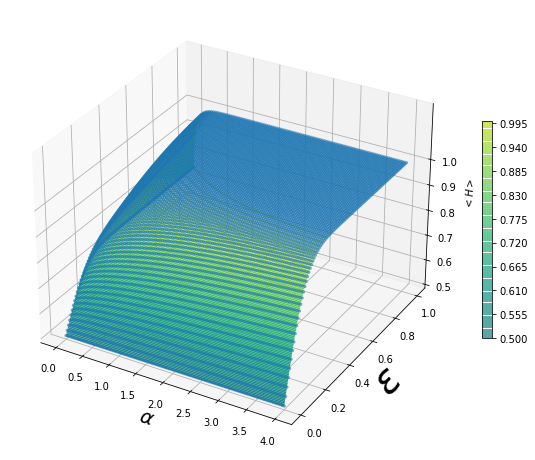

In [11]:
amps = np.linspace(0,4,100)
epsilons = np.linspace(0,1,100)
homodynes = np.zeros((len(amps), len(epsilons)))

for i,a in tqdm(enumerate(amps)):
    for j,e in enumerate(epsilons):
        homodynes[i,j]=fading_homodyne_success(a,epsilon1=e)
        
ampsgrid, epsgrid = np.meshgrid(amps, epsilons)
fig = plt.figure(figsize=(10,20))

ax = plt.axes(projection='3d')
im=ax.contour3D(ampsgrid,epsgrid, homodynes, 100,vmin=0,vmax=1.1)
ax.scatter(ampsgrid, epsgrid, homodynes,s=5, alpha=0.5)

colorbar =fig.colorbar(im,ax=ax, orientation="vertical",shrink=0.2)

ax.set_zticks(np.arange(0,1.1,.1))
ax.set_zlim([.5,1.2])

ax.set_xlabel(r'$\alpha$',size=20)
ax.set_ylabel(r'$\epsilon$',size=40)
ax.set_zlabel(r'$<H>$')

### Adaptive receiver

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import optimize, linalg
from math import erf, erfc
from scipy.optimize import *
import os
from agent import Agent


channels = {}
channels[1] = [[.5,.5],[.01,1]]
channels[2] = [[.5,.5],[.9, 1.]]
channels[3] = [[.5,.5],[.5, .55]]
channels[4] = [[.5,.5],[.001, 1.]]
channels[5] = [[.5,.5],[.00001, 1.]]
channels[6] = [[.5,.5],[.000001, 1.]]
channels[7] = [[.5,.5],[.5, .9]]
channels[8] = [[.5,.5],[.3, .4]]
channels[9] = [[.5,.5],[.3, .5]]
channels[10] = [[.5,.5], [.4, .9]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:


def Pr(alpha, beta, bs_at, outcome, channel_params=None):
    if channel_params is None:
        p= np.exp(-abs(alpha + beta)**2)
    else:
        pis, ats = channel_params #### [[pi, 1-pi], [epsilon, 1]]
        p=0
        for pfading, at in zip(pis,ats):
           p+= pfading*np.exp(-abs(np.sqrt(at)*alpha*bs_at + beta)**2)
    if outcome==0.:
        return p
    else:
        return 1-p
    
def Ptotoutcome(prior_plus,alpha,beta, bs_at, outcome, channel_params=None):
    return prior_plus*Pr(alpha,beta, bs_at, outcome,channel_params) + (1-prior_plus)*Pr(-alpha,beta, bs_at, outcome, channel_params)

def error_probability_1L(betas, amplitude, channel):
    b0= betas[0]
    p=0
    for n1 in [0.,1.]:
        ph = [-1,1][np.argmax([Pr(ph*amplitude, b0 ,1, n1, channel) for ph in [-1,1]])]
        p+=Pr(ph*amplitude, b0 ,1, n1, channel)/2
    return 1-p


def error_probability_2L(betas, amplitude, channel):
    b0, b1 ,b2 = betas
    p=0
    for n1,n2 in zip([0,0,1,1],[0,1,0,1]):
        bp = []
        for ph in [-1,1]:
            f=0
            for patt,att in zip(channel[0], channel[1]):
                f+=patt*agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/2
            bp.append(f)
        p+=np.max(bp)
    return 1-p

def give_seed(betas1,values):
    vals = np.array(values).reshape(tuple([len(betas1)]*3))
    amin = np.argmin(vals)
    indices = np.unravel_index(amin,vals.shape)
    seeds = {val: betas1[k] for val,k in enumerate(indices)}
    seeds = list(seeds.values())
    return seeds

def give_scan(a):
    if a<1:
        betas1 = np.linspace(-1,1,10)
        lim=1
    else:
        betas1 = np.linspace(-2*a,2*a,10)
        lim=3*a
    return betas1, lim




agent = Agent()
amps=np.linspace(0,3,100)


/home/cooper-cooper/Desktop/marek/agent.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.q_table = np.array(self.q_table)
/home/cooper-cooper/Desktop/marek/agent.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.n_table = np.array(self.n_table)


In [20]:
blim=amps[29]*2
fading_channel = [[.5,.5],[1,1.]]

f=dual_annealing(error_probability_2L,([(-blim,blim)])*3, args=[amps[29], fading_channel], maxiter=8000,no_local_search=True)

In [19]:
1-f.fun

0.983143702953525

1it [00:00,  9.35it/s]


****
Doing channel case 1


100it [00:09, 10.73it/s]
100it [18:18, 10.98s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
1it [00:00,  9.37it/s]


****
Doing channel case 2


100it [00:08, 11.21it/s]
100it [14:53,  8.93s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
4it [00:00, 14.23it/s]


****
Doing channel case 3


100it [00:07, 14.06it/s]
100it [13:00,  7.80s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
2it [00:00, 19.15it/s]


****
Doing channel case 4


100it [00:05, 17.56it/s]
100it [14:30,  8.70s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
4it [00:00, 15.64it/s]


****
Doing channel case 5


100it [00:06, 14.94it/s]
100it [13:13,  7.94s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
2it [00:00, 15.40it/s]


****
Doing channel case 6


100it [00:06, 14.97it/s]
100it [13:12,  7.92s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
4it [00:00, 15.98it/s]


****
Doing channel case 7


100it [00:06, 14.86it/s]
100it [13:21,  8.01s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
2it [00:00, 16.63it/s]


****
Doing channel case 8


100it [00:06, 14.98it/s]
100it [13:18,  7.98s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
2it [00:00, 15.48it/s]


****
Doing channel case 9


100it [00:06, 14.92it/s]
100it [13:22,  8.03s/it]
0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
4it [00:00, 15.73it/s]


****
Doing channel case 10


100it [00:06, 14.95it/s]
100it [13:13,  7.94s/it]


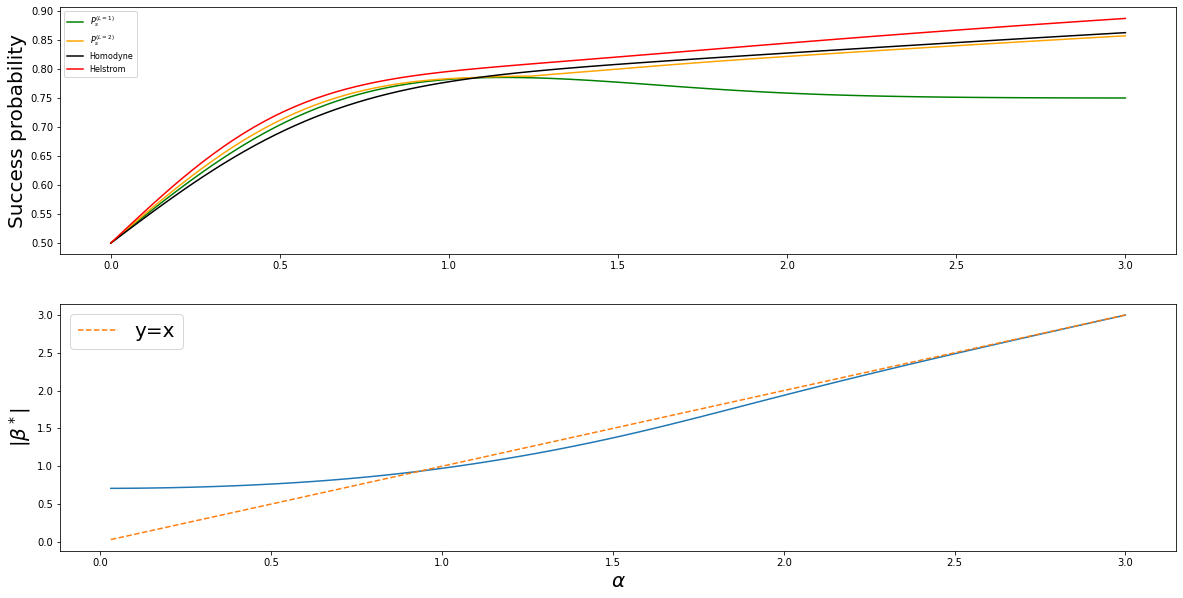

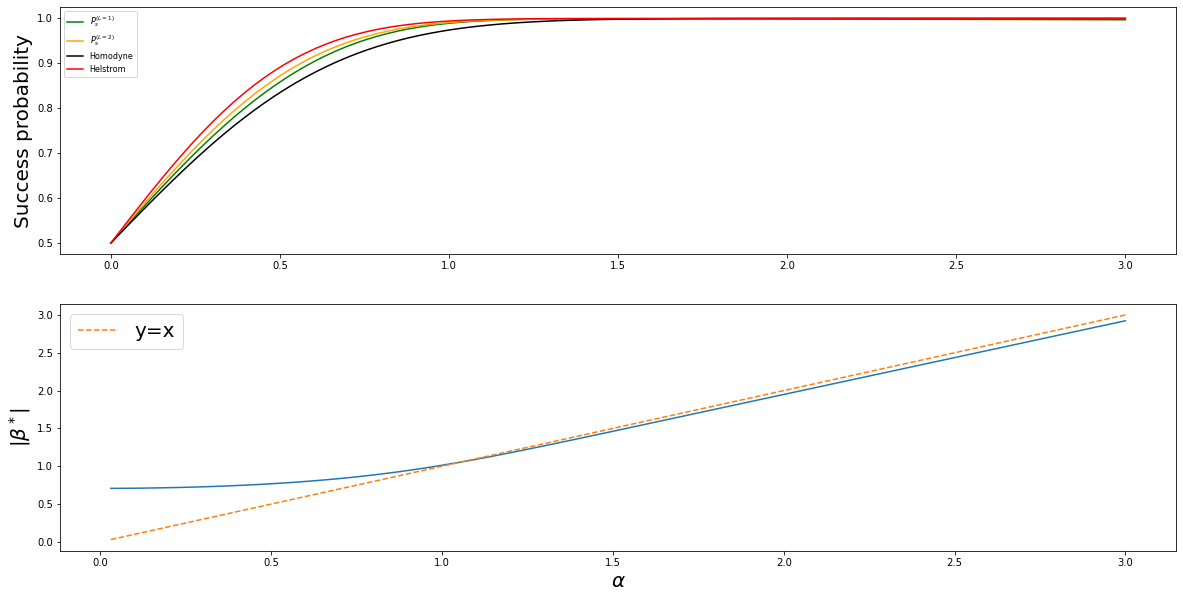

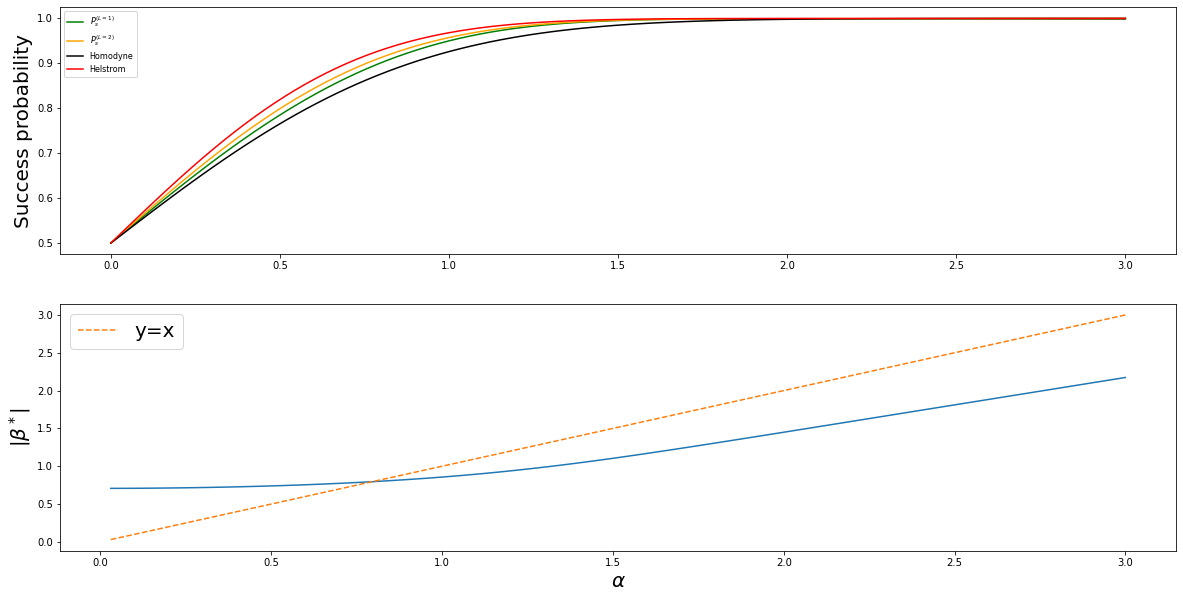

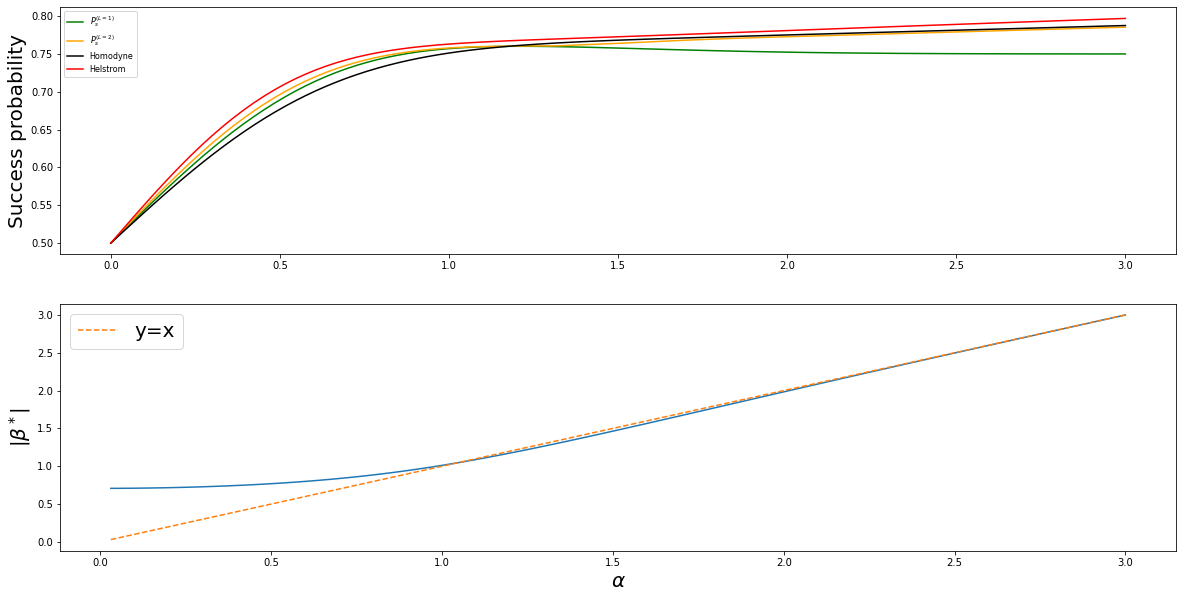

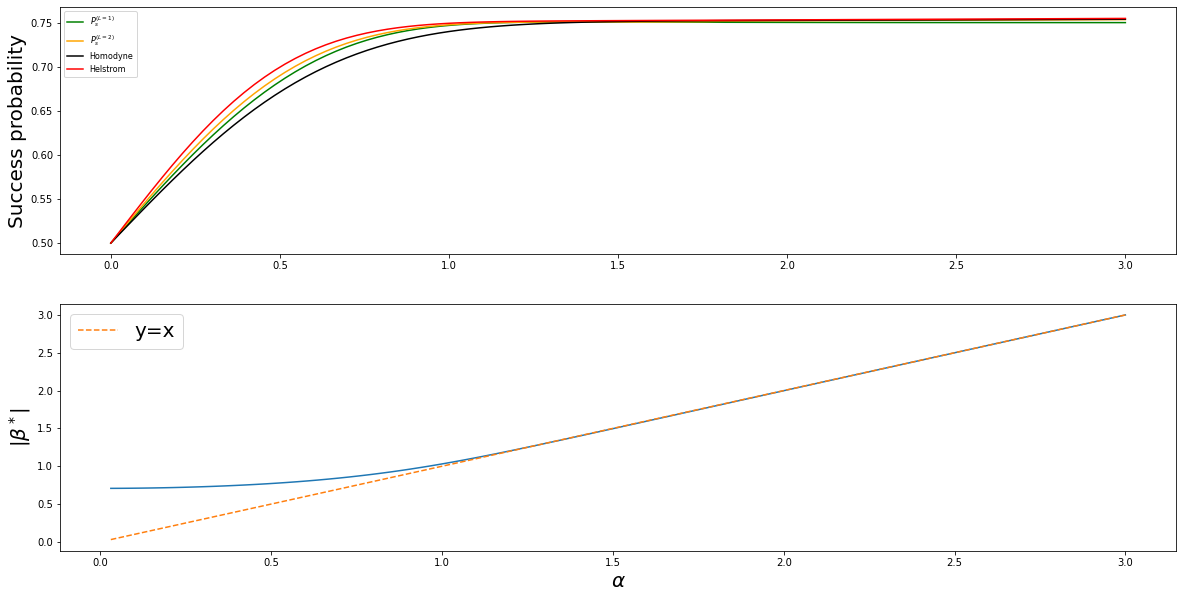

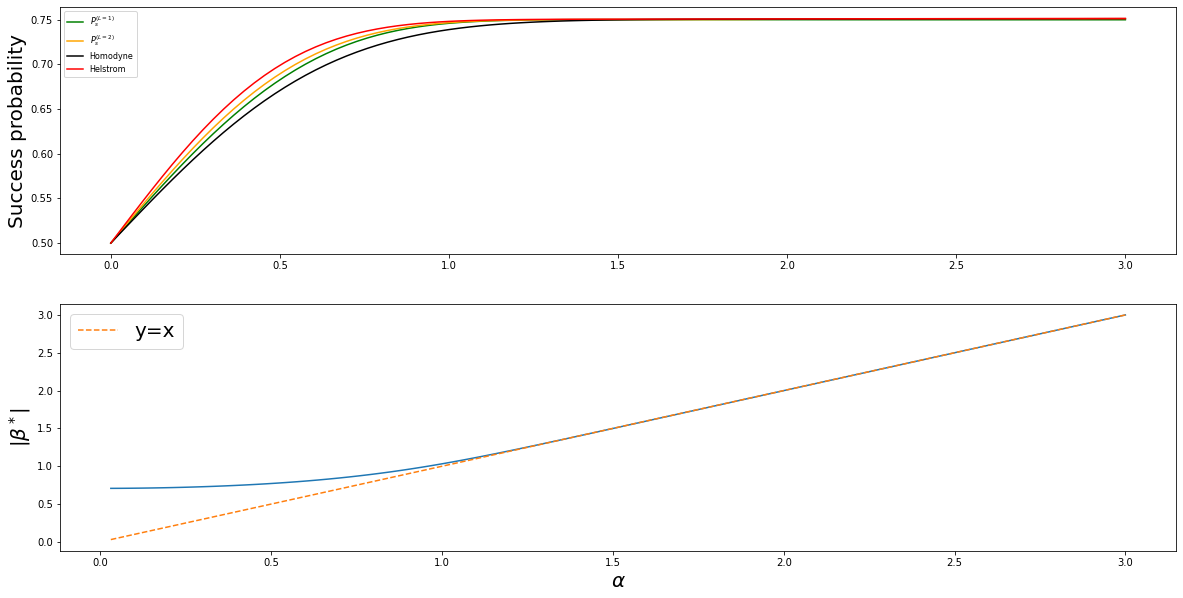

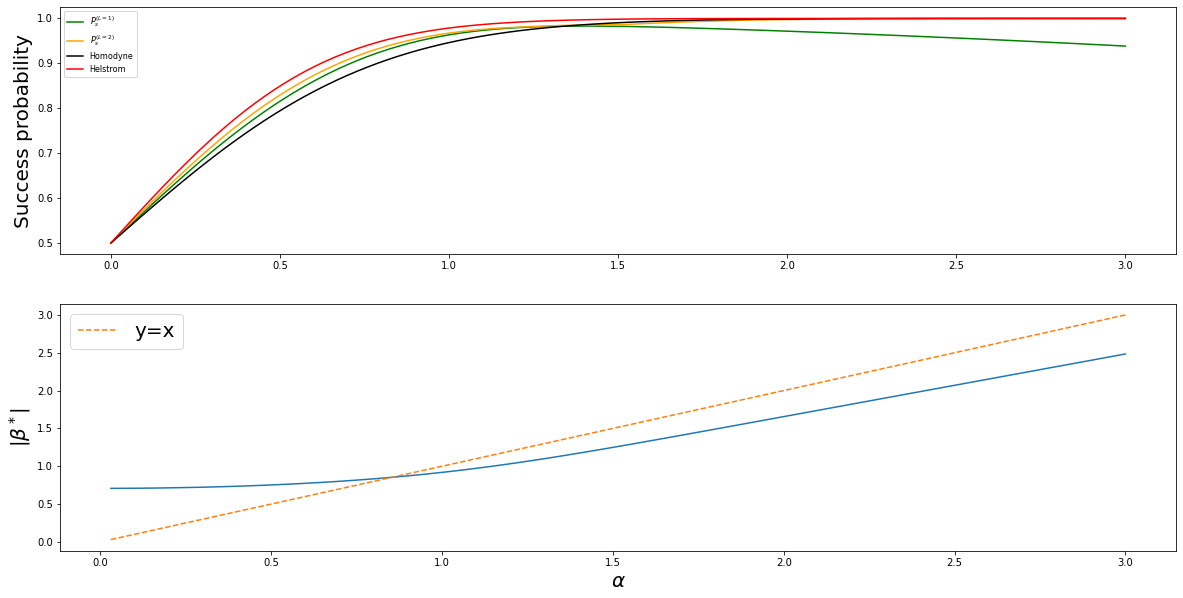

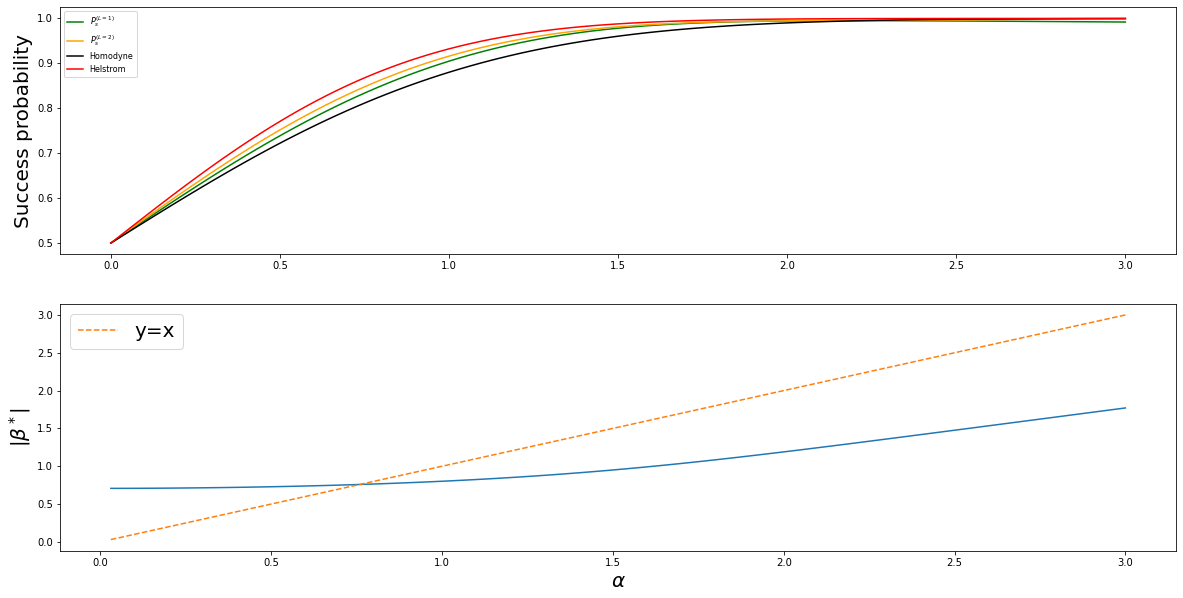

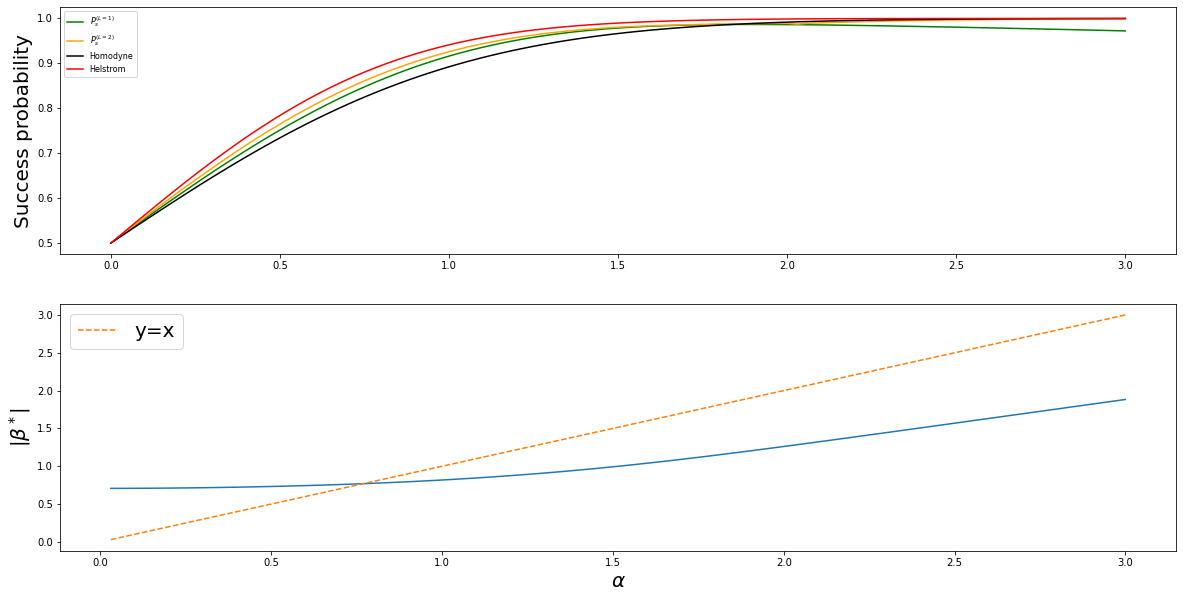

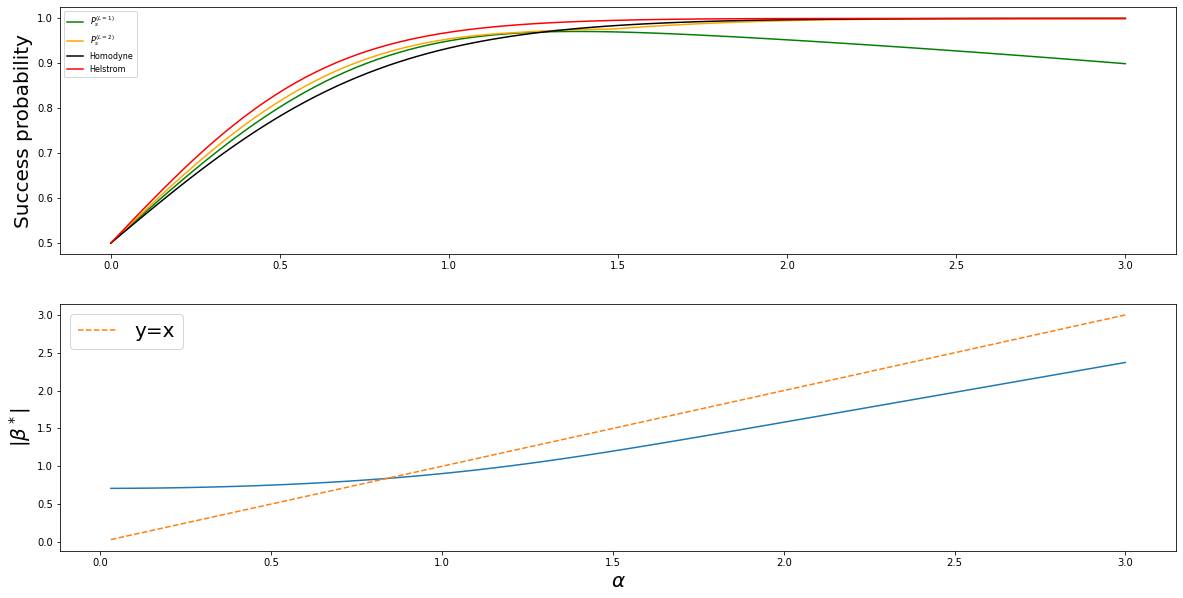

In [32]:

for caseid in range(1,11):
    print("\n****\nDoing channel case {}".format(caseid))

    attenuations = channels[caseid][1]
    fading_channel = channels[caseid]
    betas = np.linspace(-max(amps)*2,2*max(amps),1000)
    s1,fun1 = np.zeros((2,len(amps)))
    s2 = np.zeros((len(amps)))
    fun2 = np.zeros((len(amps),3))

    for inda,a in tqdm(enumerate(amps)):

        seed = betas[np.argmin([error_probability_1L([b], a, fading_channel) for b in betas])]
        ff = minimize(error_probability_1L,x0=seed, method="BFGS", args=(a,fading_channel),bounds=[tuple([None, None])])
        #ff = dual_annealing(success_probability_1L, args=(a,fading_channel),bounds=[tuple([None, None])])

        s1[inda]= 1-ff.fun
        fun1[inda]= ff.x


    for inda,a in tqdm(enumerate(amps)):

        ### this led to no improvement...
        betas1, blim = give_scan(a)
        va = [error_probability_2L([b1,b2,b3], a, fading_channel) for b1 in betas1 for b2 in betas1 for b3 in betas1]
        seed = give_seed(betas1,va)
        ####

        f=dual_annealing(error_probability_2L,([(-blim,blim)])*3, args=[a, fading_channel], maxiter=5000,no_local_search=True)
        s2[inda] = 1-f.fun
        fun2[inda] = f.x

        
    homodynes_values = np.array([fading_homodyne_success(a, epsilon1=attenuations[0], epsilon2=attenuations[1]) for a in amps])
    helstroms_values = np.array([helstrom_success_fun(a,epsilon1=attenuations[0], epsilon2=attenuations[1]) for a in amps])

    os.makedirs("data_cases/{}".format(caseid),exist_ok=True)
    np.save("data_cases/{}/ar_2L_s".format(caseid),s2)
    np.save("data_cases/{}/ar_2L_betas".format(caseid),fun2)
    np.save("data_cases/{}/ar_1L_s".format(caseid),s1)
    np.save("data_cases/{}/ar_1L_betas".format(caseid),fun1)
    np.save("data_cases/{}/homodynes".format(caseid),homodynes_values)
    np.save("data_cases/{}/helstroms".format(caseid),helstroms_values)

    
    plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(amps,s1, color="green",label=r'$P^{(L=1)}_s$')
    plt.plot(amps,s2,color="orange", label=r'$P^{(L=2)}_s$')
    
    plt.plot(amps,homodynes_values, color="black", label="Homodyne")
    plt.plot(amps,helstroms_values, color="red", label="Helstrom")
    
    plt.ylabel("Success probability",size=20)
    plt.legend(prop={"size":8})
    plt.subplot(212)
    plt.plot(amps[1:], np.abs(fun1)[1:])
    plt.plot(amps[1:], amps[1:],'--', label="y=x")
    plt.legend(prop={"size":20})
    plt.ylabel(r'$|\beta^*|$',size=20)
    plt.xlabel(r'$\alpha$',size=20)
    plt.savefig("data_cases/{}/figure.png".format(caseid))

 CASE9:
attenuations:  [0.3, 0.5]


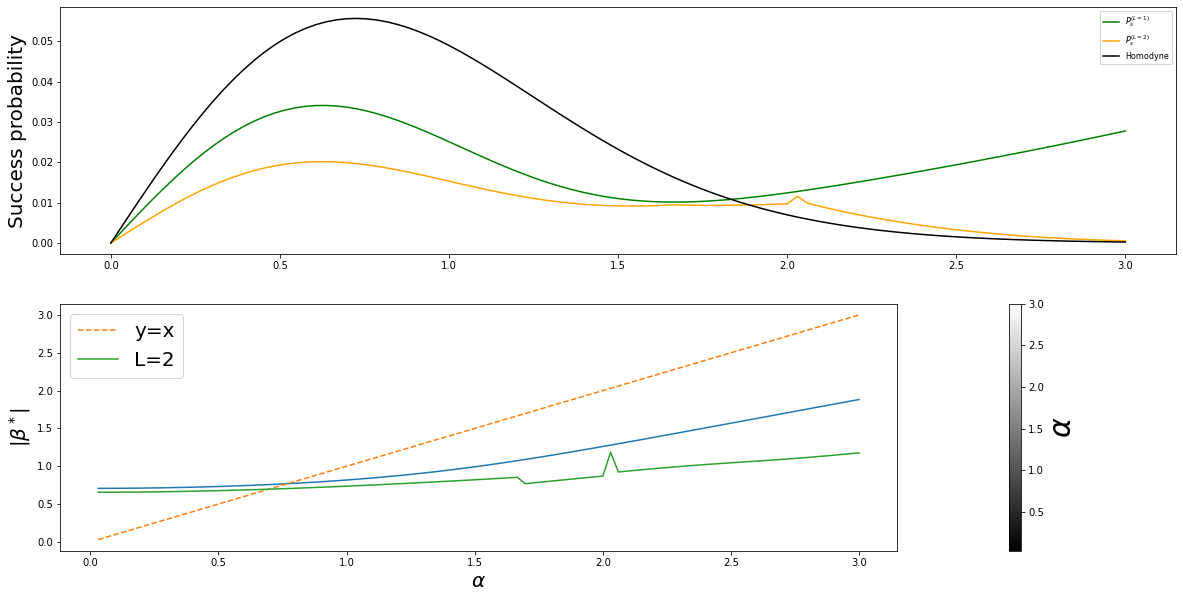

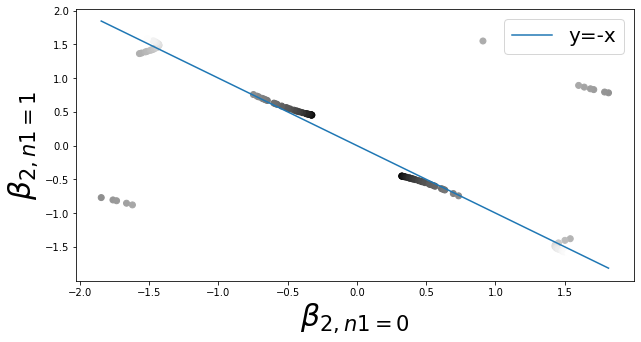

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------






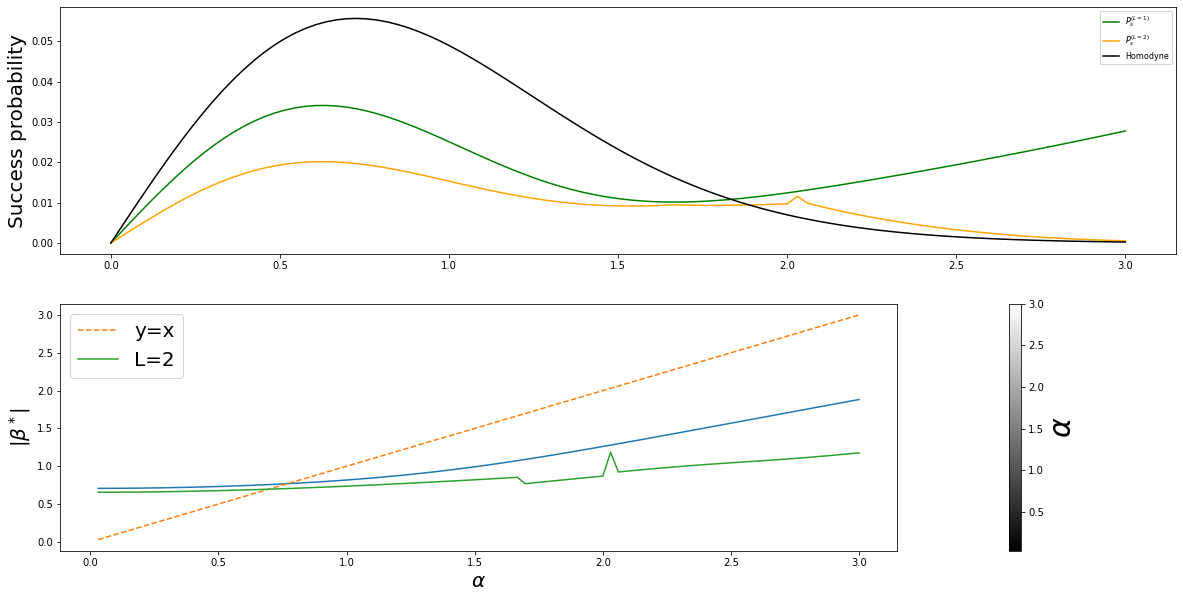

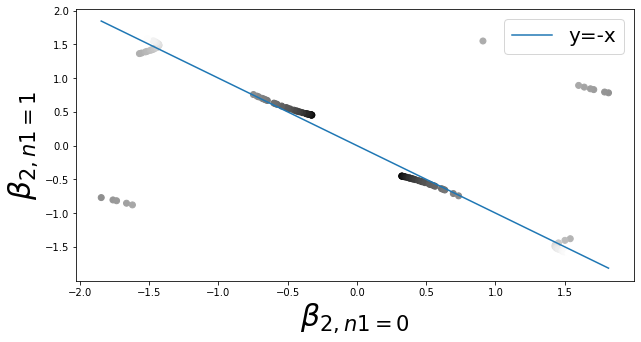

In [24]:

amps=np.linspace(0,3,100)
ind=len(amps)

for caseid in range(9,10):
    print("\033[1m CASE{}:".format(caseid))
    print("attenuations: ",channels[caseid][1])
    

    s2=np.load("data_cases/{}/ar_2L_s.npy".format(caseid))
    fun2=np.load("data_cases/{}/ar_2L_betas.npy".format(caseid))#,fun2)
    s1=np.load("data_cases/{}/ar_1L_s.npy".format(caseid))#,s1)
    fun1=np.load("data_cases/{}/ar_1L_betas.npy".format(caseid))#,fun1)
    homodynes_values=np.load("data_cases/{}/homodynes.npy".format(caseid))#,homodynes_values)
    helstroms_values=np.load("data_cases/{}/helstroms.npy".format(caseid))#,helstroms_values)


    fig1=plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(amps,helstroms_values-s1, color="green",label=r'$P^{(L=1)}_s$')
    plt.plot(amps,helstroms_values-s2,color="orange", label=r'$P^{(L=2)}_s$')

    plt.plot(amps,helstroms_values-homodynes_values, color="black", label="Homodyne")
    #plt.plot(amps,helstroms_values, color="red", label="Helstrom")

    #plt.plot(amps,[0.75]*len(amps), '--',linewidth=0.8,color="blue", label="y=0.75")
    plt.ylabel("Success probability",size=20)
    plt.legend(prop={"size":8})
    plt.subplot(212)
    plt.plot(amps[1:], np.abs(fun1)[1:])
    plt.plot(amps[1:], amps[1:],'--', label="y=x")
    plt.plot(amps[1:],np.abs(fun2[:,0])[1:], label="L=2")
    plt.legend(prop={"size":20})
    plt.ylabel(r'$|\beta^*|$',size=20)
    plt.xlabel(r'$\alpha$',size=20)

    x = np.linspace(min(fun2[:,2]), max(fun2[:,2]),100)
    fig2=plt.figure(figsize=(10,5))
    im=plt.scatter(fun2[:,2][1:ind],fun2[:,1][1:ind], c=amps[1:ind],cmap="gray")#, '.',label="L=2")
    cb=fig1.colorbar(im,label=r'$\alpha$',pad=0.1)
    cb.set_label(label=r'$\alpha$',size=30, weight='bold')

    plt.plot(x,-x, label="y=-x")
    plt.xlabel(r'$\beta_{2,n1=0}$',size=30)
    plt.ylabel(r'$\beta_{2,n1=1}$',size=30)

    plt.legend(prop={"size":20})
    #plt.plot(amps[1:ind],, label="L=2")
    display(fig1)
    display(fig2)
    print("---"*60)
    print("---"*60)
    
    print("\n"*3)
    

## Generate plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


amps=np.linspace(0,3,100)
ind=len(amps)


channels = {}
channels[1] = [[.5,.5],[.01,1]]
channels[2] = [[.5,.5],[.9, 1.]]
channels[3] = [[.5,.5],[.5, .55]]
channels[4] = [[.5,.5],[.001, 1.]]
channels[5] = [[.5,.5],[.00001, 1.]]
channels[6] = [[.5,.5],[.000001, 1.]]
channels[7] = [[.5,.5],[.5, .9]]
channels[8] = [[.5,.5],[.3, .4]]
channels[9] = [[.5,.5],[.3, .5]]

for caseid in range(1,10):
    

    colors={"1L":list(np.array([15,12,12])/255.),
           "2L":list(np.array([216,169,20])/255.),
           "H": list(np.array([183,121,249])/255.)}

    s2=np.load("data_cases/{}/ar_2L_s.npy".format(caseid))
    fun2=np.load("data_cases/{}/ar_2L_betas.npy".format(caseid))#,fun2)
    s1=np.load("data_cases/{}/ar_1L_s.npy".format(caseid))#,s1)
    fun1=np.load("data_cases/{}/ar_1L_betas.npy".format(caseid))#,fun1)
    homodynes_values=np.load("data_cases/{}/homodynes.npy".format(caseid))#,homodynes_values)
    helstroms_values=np.load("data_cases/{}/helstroms.npy".format(caseid))#,helstroms_values)


    lw=10
    al=0.8
    fig1=plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.plot(amps,helstroms_values-s1, color=colors["1L"], linewidth=lw,label=r'$P_{\rm s}^{\rm op}-P^{(L=1)}_s$', alpha=al)
    plt.plot(amps,helstroms_values-s2,color=colors["2L"], linewidth=lw, label=r'$P_{\rm s}^{\rm op}-P^{(L=2)}_s$', alpha=al)
    plt.plot(amps,helstroms_values-homodynes_values, color=colors["H"],  linewidth=lw,label=r'$P_{\rm s}^{\rm op} - P_{\rm s}^{\rm hom}$', alpha=al)
    plt.ylabel("Success probability",size=40)
    plt.legend(prop={"size":30}, loc=0)
    plt.xticks(fontsize=20)#, rotation=90)
    plt.yticks(fontsize=20)#, rotation=90)
    plt.xlabel(r'$\alpha$',size=40)
    os.makedirs("paper_plots",exist_ok=True)
    plt.savefig("paper_plots/{}.pdf".format("etas" + str(channels[caseid][1])))